Interaction with frontal camera! Run on local PC, not in Colab.

## Camera setup

In [1]:
import cv2
import torch

from torch import nn
from torchvision import models

import matplotlib.pyplot as plt
import torchvision.transforms as T

In [2]:
# запускаем камеру
cam = cv2.VideoCapture(0)

if not cam.isOpened():
    print("Не удалось открыть камеру")
else:
    print("Камера запущена")

cam.set(cv2.CAP_PROP_FRAME_WIDTH, 640) # ширина кадра -- 640 пикселей
cam.set(cv2.CAP_PROP_FRAME_HEIGHT, 480) # высота кадра -- 480 пикселей

Камера запущена


True

In [4]:
# отдельно, так как эта часть не знает про train папки. Однако порядок эмоций сохранен (просто скопировал)

emotions = ['surprise', 'sad', 'happy', 'contempt', 'neutral', 'anger', 'fear', 'uncertain', 'disgust']
idx2emotions = {i:v for i, v in enumerate(emotions)}

face_detector = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

## Emotion recognition model

In [5]:
# модель для классификации
# просто копируем класс классификационной сети и грузим предобученные веса

class Net(nn.Module):
    def __init__(self, num_classes=9, embedding_len=256):
        super(Net, self).__init__()
        self.pretrained = models.resnet34(weights='IMAGENET1K_V1')
        self.embedding = nn.Linear(1000, embedding_len)
        self.bn = nn.BatchNorm1d(embedding_len)
        self.output = nn.Linear(embedding_len, num_classes)

    def forward(self, x):
        x = self.pretrained(x)
        x = self.embedding(x)
        x = self.bn(x)
        x = self.output(x)
        return x


# модель распознавания эмоций

class EmotionRecognitionModel(nn.Module):
    def __init__(self, weight_path, cam, face_detector):
        super(EmotionRecognitionModel, self).__init__()
        self.model = torch.load(weight_path, map_location=torch.device('cpu'))
        self.transform = T.Compose([T.ToTensor(), T.Resize((48,48))])
        self.cam = cam
        self.face_detector = face_detector

    def get_frame(self, cam, face_detector):
        ret, frame = cam.read()
        assert ret == True

        # фишка cv2 - BRG изображения
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        grayscale_image = cv2.cvtColor(rgb_frame, cv2.COLOR_RGB2GRAY)

        # распознаем лицо
        faces = face_detector.detectMultiScale(grayscale_image, 1.3, 5)
        if len(faces) == 0:
            print('Лицо не распознано')
            return 1

        # выделяем его из кадра
        one_face = faces[0]
        x, y, w, h = one_face
        face_boundingbox_rgb = rgb_frame[y:y + h, x:x + w]

        return face_boundingbox_rgb

    def predict(self):
        frame = self.get_frame(self.cam, self.face_detector)
        if isinstance(frame, int):
            return None, 'Нет лица - нет эмоции'
        image = self.transform(frame)
        image = image / 255.

        outputs = self.model(image.unsqueeze(0))
        _, preds = torch.max(outputs, 1)
        return frame, idx2emotions[preds.numpy()[0]]

In [6]:
erm = EmotionRecognitionModel(weight_path='./resnet_34_7e.pth', cam=cam, face_detector=face_detector)

## Inference

In [9]:
frame, pred = erm.predict()

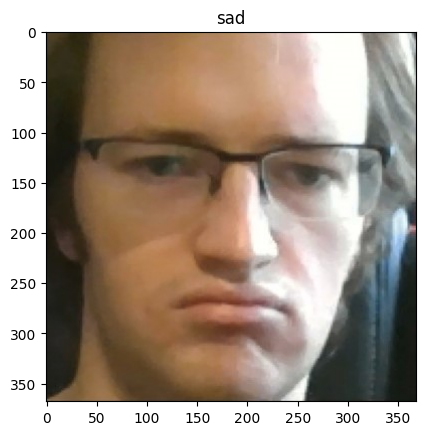

In [12]:
# это недовольный я

if frame is None:
    print(pred)
else:
    plt.imshow(frame)
    plt.title(pred)
    plt.show()

Инференс можно запускать в цикле. Таким образом получится распознавание эмоций в режиме онлайн.